In [1]:
# install dependencies
!pip install gym --upgrade
!pip install pyglet
!pip install Box2D
!pip install box2d-py
!pip install gym[Box_2D]
!pip install gym[box2d]

     |████████████████████████████████| 626 kB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.23.1-py3-none-any.whl size=701376 sha256=e2194f66eab2c2d219a0cddc794e03e3a35f58bb5515036536a5cce98582e671
  Stored in directory: /root/.cache/pip/wheels/e3/33/04/6723848e46f0f1ebe794bb329b7c761c3329a0d7ffade99da7
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3
     |████████████████████████████████| 1.3 MB 5.3 MB/s 
     |████████████████████████████████| 448 kB 5.2 MB/s 
     |████████████████████████████████| 18.3 MB 89 kB/s 
     |████████████████████████████████| 2.1 MB 32.4 MB/s 
  Attempting uninstall: box2d-py
    Found existing installation: box2d-py 2.3.8
    Uninstalling box2d-py-2.3.8:
      Successfully uninstalled box2d-py-2.3.8


In [1]:
import torch

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device # cpu on my laptop, CUDA on google colab.

device(type='cpu')

In [2]:
# enviroment
import gym

env = gym.make('LunarLander-v2')
state_size =  env.observation_space.shape[0]
action_size =  env.action_space.n

In [3]:
# experience replay
import random
from collections import namedtuple, deque

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))


class ExperienceReplay():
    def __init__(self, capacity) -> None:
        self.memory = deque([], maxlen=capacity)
        
    def store_trans(self, s, a, sp, r, done):
        # TODO: store new transition in memory
        newtransition = Transition(s, a, sp, r, done)
        self.memory.append(newtransition)
        pass

    def sample(self, batch_size):
        # TODO: take RANDOM sample from memory
        return random.sample(self.memory, batch_size)
        pass

    def __len__(self):
        return len(self.memory)

In [4]:
# DQN
import torch.nn as nn
import torch.nn.functional as F

class DeepQNetwork(nn.Module):
    def __init__(self, state_size, action_size) -> None:
        super(DeepQNetwork, self).__init__()
        # TODO: define the architecture
        # NOTE: input=observation/state, output=action
        self.layer1 = nn.Linear(state_size, 256)
        self.layer2 = nn.Linear(256, 512)
        self.layer3 = nn.Linear(512, 128)
        self.layer4 = nn.Linear(128, action_size)
        pass

    def forward(self, x):
        # TODO: forward propagation
        # NOTE: use ReLu for activation function in all layers 
        x = x.to(device)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        # NOTE: last layer has no activation function (predict action)
        return self.layer4(x)

In [6]:
# DQN agent
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DQNAgent():
    # NOTE: DON'T change initial values
    def __init__(self, state_size, action_size, batch_size,
                 gamma=0.99, buffer_size=25000, alpha=1e-4):
        # network parameter
        self.state_size = state_size
        self.action_size = action_size

        # hyperparameters
        self.batch_size = batch_size
        self.gamma = gamma

        # experience replay
        self.experience_replay = ExperienceReplay(buffer_size)

        # network
        self.value_net = DeepQNetwork(state_size, action_size).to(device)

        # optimizer
        # TODO: create adam for optimizing network's parameter (learning rate=alpha)
        self.optimizer = optim.Adam(self.value_net.parameters(), lr=alpha)


    def take_action(self, state, eps=0.0):
        # TODO: take action using e-greedy policy
        # NOTE: takes action using the greedy policy with a probability of 1−𝜖 and a random action with a probability of 𝜖
        # NOTE: 
        ### Convert "state" into torch tesnor
        state = torch.from_numpy(state).float().to(device)
        ### Convert into 1-dim tensor
        state = state.unsqueeze(0).to(device)
        ### Switch to evaluation mode to get possible action values
        self.value_net.eval()
        with torch.no_grad():
            action_values = self.value_net(state)
        ### Switch back to training mode
        self.value_net.train()

        if random.random() > eps:   ###Exploit
            return action_values.argmax(dim=1).item()
        else:                       ###Explore
            return random.choice(np.arange(self.action_size))
        
        pass

    def update_params(self):
        if len(self.experience_replay) < self.batch_size:
            return
        # transition batch
        batch = Transition(*zip(*self.experience_replay.sample(self.batch_size)))

        state_batch = torch.from_numpy(np.vstack(batch.state)).float().to(device)
        action_batch = torch.tensor(np.vstack(batch.action)).long().to(device)
        next_state_batch = torch.from_numpy(np.vstack(batch.next_state)).float().to(device)
        reward_batch = torch.tensor(np.vstack(batch.reward)).float().to(device)
        done_batch = torch.tensor(np.vstack(batch.done)).to(device)

        # calculate loss w.r.t DQN algorithm

        # STEP1
        # TODO: compute the expected Q values [y]

        ### calculate expected Q for next state
        next_Q = self.value_net(next_state_batch).detach()
        max_next_Q = torch.max(next_Q, 1)[0].unsqueeze(1) # expected Q
        
        ### use the bellman equation to compute Q
        expected_Q = reward_batch + self.gamma * (~done_batch) * max_next_Q
        
        # STEP2
        # TODO: compute Q values [Q(s_t, a)]
        
        
        ### use state batch for computing current Q values for this batch;
        ### to do so, we have to input the state_batch into the DQN, and use
        ### torch.gather to gather output for the actions we have taken.
        current_Q = self.value_net(state_batch).gather(1,action_batch)
        
        # STEP3
        # TODO: compute mse loss
        loss = F.mse_loss(current_Q, expected_Q)
        
        # TODO: optimize the model
        # NOTE: DON'T forget to set the gradients to zeros
        
        self.optimizer.zero_grad()     ### set gradients to zero
        loss.backward()                ### backpropagate the losses (calculate gradients)
        self.optimizer.step()          ### update model parameters

    def update_experience(self, s, a, sp, r, done):
        ### Method for adding transision into experience buffer
        self.experience_replay.store_trans(s, a, sp, r, done)
        
    def save(self, fname):
        # TODO: save checkpoint
        torch.save(self.value_net, fname)
        pass

    def load(self, fname, device):
        # TODO: load checkpoint
        #لپتاپ بنده فقط با سی پی یو می تواند کار کند.
        #برای لود کردن شبکه روی لپتاپ باید با سی پی یو لود کنم.
        self.value_net = torch.load(fname,map_location=torch.device('cpu')).to(device) 
        pass

In [18]:
# NOTE: DON'T change values
n_episodes = 250
eps = 1.0
eps_decay_rate = 0.97
eps_end = 0.01

# Train Using DQN

In [8]:
# training phase

# TODO: create agent
batch_size = 64              # set batch size
agent = DQNAgent(state_size, action_size, batch_size)

crs = np.zeros(n_episodes)    # cummulative rewards
crs_recent = deque(maxlen=25) # recent cummulative rewards
# training loop
for i_episode in range(1, n_episodes+1):
    # TODO: initialize the environment and state
    done = 0
    state = env.reset()
    cr = 0 # episode cummulative rewards
    while not done:
        # TODO: select and perform an action
        action = agent.take_action(state, eps)           ### select the action, input current state and current epsilon value
        next_state, reward, done, inf = env.step(action) ### perform the action
        # TODO: store transition in experience replay
        agent.update_experience(state, action, next_state, reward, done)
        # TODO: update agent
        agent.update_params()
        # TODO: update current state and episode cummulative rewards
        state = next_state
        cr += reward
    crs[i_episode-1] = cr
    
    # TODO: decay epsilon
    eps = max(eps_end, eps_decay_rate*eps)
    # TODO: update current cummulative rewards and recent cummulative rewards
    np.append(crs, cr)
    crs_recent.append(cr)
    # TODO: save agent every 50 episodes
    if (i_episode % 50 == 0):
        agent.save('dqn_episode'+str(i_episode)+'.pt')
    # print logs
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
    if i_episode % 25 == 0:
        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))

Episode 25	Average Reward: -130.76	Epsilon: 0.47
Episode 50	Average Reward: -57.74	Epsilon: 0.22
Episode 75	Average Reward: 32.47	Epsilon: 0.10
Episode 100	Average Reward: 168.32	Epsilon: 0.05
Episode 125	Average Reward: 230.07	Epsilon: 0.02
Episode 150	Average Reward: 197.83	Epsilon: 0.01
Episode 175	Average Reward: 223.67	Epsilon: 0.01
Episode 200	Average Reward: 217.95	Epsilon: 0.01
Episode 225	Average Reward: 237.23	Epsilon: 0.01
Episode 250	Average Reward: 257.48	Epsilon: 0.01


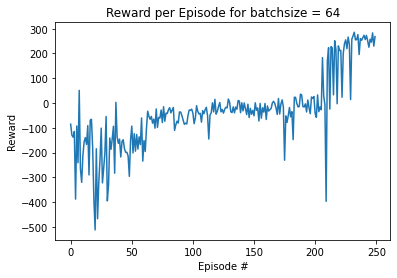

In [ ]:
import matplotlib.pyplot as plt
plt.plot(crs)
plt.title('Reward per Episode for batchsize = {:d}'.format(batch_size))
plt.xlabel('Episode #')
plt.ylabel('Reward')
plt.show()

# Show trained network in episodes 50,100,150,200,250

In [ ]:
batch_size = 64              # set batch size
agent = DQNAgent(state_size, action_size, batch_size)
eps = 250
done = False
reward = 0
state = env.reset()
agent.load('dqn_episode'+str(eps)+'.pt', device)
while not done:
    env.render()
    action = agent.take_action(state, eps)
    state, reward, done, _ = env.step(action)
env.close()

# Record trained network in episodes 50,100,150,200,250

In [ ]:
from gym.wrappers.monitoring import video_recorder
batch_size = 64              # set batch size
agent = DQNAgent(state_size, action_size, batch_size)
for eps in np.linspace(50,250,5, dtype=int):
    vid = video_recorder.VideoRecorder(env, path="videos/dqn_eps_{}.mp4".format(eps))
    agent.load('dqn_episode'+str(eps)+'.pt', device)
    state = env.reset()
    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        vid.capture_frame()
        action = agent.take_action(state)
        state, reward, done, _ = env.step(action)
    env.close()

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DDQNAgent():
    # NOTE: DON'T change initial values
    def __init__(self, state_size, action_size, batch_size,
                 gamma=0.99, buffer_size=25000, alpha=1e-4):
        # network parameter
        self.state_size = state_size
        self.action_size = action_size

        # hyperparameters
        self.batch_size = batch_size
        self.gamma = gamma

        # experience replay
        self.replay_buffer = ExperienceReplay(buffer_size)

        # networks
        self.value_net = DeepQNetwork(state_size, action_size).to(device)
        self.target_value_net = DeepQNetwork(state_size, action_size).to(device)
        self.target_value_net.eval()
        self.update_target_network()
        self.timer = 0  ## timer for updating the target network
        # optimizer
        # TODO: create adam for optimizing network's parameter (learning rate=alpha)
        # NOTE: target network parameters DOSEN'T update with optimizer
        self.optimizer = optim.Adam(self.value_net.parameters(), lr=alpha)


    def take_action(self, state, eps=0.0):
        # TODO: take action using e-greedy policy
        # NOTE: takes action using the greedy policy with a probability of 1−𝜖 and a random action with a probability of 𝜖
        # NOTE:
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.value_net.eval() # set into evaluation mode
        with torch.no_grad():
            action_values = self.value_net(state)
        self.value_net.train() # set back to training mode

        # Epsilon-greedy action selection
        if random.random() > eps:
            return action_values.argmax(dim=1).item()
        else:
            return random.choice(np.arange(self.action_size))

        pass

    def update_params(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        # transition batch
        batch = Transition(*zip(*self.replay_buffer.sample(self.batch_size)))

        state_batch = torch.from_numpy(np.vstack(batch.state)).float().to(device)
        action_batch = torch.tensor(np.vstack(batch.action)).long().to(device)
        next_state_batch = torch.from_numpy(np.vstack(batch.next_state)).float().to(device)
        reward_batch = torch.tensor(np.vstack(batch.reward)).float().to(device)
        done_batch = torch.tensor(np.vstack(batch.done)).to(device)

        # calculate loss w.r.t DQN algorithm

        # STEP1
        # TODO: compute the expected Q values [y]
        max_next_target_Q = self.target_value_net(next_state_batch).detach().max(1)[0].unsqueeze(1)
        ### bellman equation:
        expected_Q = reward_batch + self.gamma * max_next_target_Q * (~done_batch)

        # STEP2
        # TODO: compute Q values [Q(s_t, a)]
        ### calculate Q value for current state
        current_Q = self.value_net(state_batch).gather(1, action_batch)
        
        # STEP3
        # TODO: compute mse loss
        loss = F.mse_loss(current_Q, expected_Q)
        # TODO: optimize the model
        # NOTE: DON'T forget to set the gradients to zeros
        self.optimizer.zero_grad()   ### reset gradients
        loss.backward()              ### calculate gradients
        self.optimizer.step()        ### update network
        if self.timer % 5 == 0:      ### timer for updating target network
          self.timer = 0
          self.update_target_network()

    def update_target_network(self):
        tau = 1e-3
        # TODO: copy main network parameters to target network parameters
        ### hard copy value net to target net
        self.target_value_net.load_state_dict(self.value_net.state_dict())
        pass

    def update_experience(self, s, a, sp, r, done):
        ### Method for adding transision into experience buffer
        self.replay_buffer.store_trans(s, a, sp, r, done)

    def save(self, fname):
        # TODO: save checkpoint
        torch.save(self.target_value_net,fname)
        pass

    def load(self, fname, device):
        # TODO: load checkpoint
        # روی لپتاپ من پایتورچ فقط با سی پی یو کار می کند
        # برای همین با سی پی یو شبکه را لود می کنیم.
        self.value_net = torch.load(fname, map_location=torch.device('cpu')).to(device)
        pass

In [19]:
# training phase

# TODO: create agent
batch_size = 64               # set batch size
agent = DDQNAgent(state_size, action_size, batch_size)
crs2 = np.zeros(n_episodes) # cummulative rewards
crs_recent = deque(maxlen=25) # recent cummulative rewards
state = 0
# training loop
for i_episode in range(1, n_episodes+1):
    # TODO: initialize the environment and state
    done = 0
    state = env.reset()
    cr = 0 # episode cummulative rewards
    agent.timer = 1
    while not done:
        # TODO: select and perform an action
        
        action = agent.take_action(state, eps)           ### select the action, input current state and current epsilon value
        next_state, reward, done, _ = env.step(action)   ### perform the action
        # TODO: store transition in experience replay
        agent.update_experience(state, action, next_state, reward, done)
        # TODO: update agent
        agent.update_params()
        # TODO: update current state and episode cummulative rewards
        state = next_state
        cr += reward
        # timer used to update target network every 5 actions:
        agent.timer += 1
    # TODO: decay epsilon
    eps = max(eps_end, eps_decay_rate*eps)
    # TODO: update current cummulative rewards and recent cummulative rewards
    crs2[i_episode-1] = cr
    crs_recent.append(cr)
    # TODO: save agent every 50 episodes
    if (i_episode % 50 == 0):
        agent.save('ddqn_episode_'+str(i_episode)+'.pt')
    # print logs
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
    if i_episode % 25 == 0:
        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))

Episode 25	Average Reward: -136.36	Epsilon: 0.47
Episode 50	Average Reward: -50.29	Epsilon: 0.22
Episode 75	Average Reward: -39.65	Epsilon: 0.10
Episode 100	Average Reward: -20.12	Epsilon: 0.05
Episode 125	Average Reward: 93.64	Epsilon: 0.02
Episode 150	Average Reward: 213.05	Epsilon: 0.01
Episode 175	Average Reward: 220.02	Epsilon: 0.01
Episode 200	Average Reward: 218.11	Epsilon: 0.01
Episode 225	Average Reward: 254.91	Epsilon: 0.01
Episode 250	Average Reward: 249.97	Epsilon: 0.01


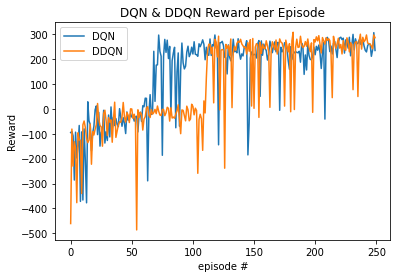

In [20]:
import matplotlib.pyplot as plt
plt.plot(crs)
plt.plot(crs2)
plt.title('DQN & DDQN Reward per Episode')
plt.legend(['DQN', 'DDQN'])
plt.xlabel('episode #')
plt.ylabel('Reward')
plt.show()

# Record Trained DDQN Network in 100, 250

In [6]:
from gym.wrappers.monitoring import video_recorder
batch_size = 64              # set batch size
agent = DDQNAgent(state_size, action_size, batch_size)
for eps in [100, 250]:
    filename = "videos/ddqn_eps_{}.mp4".format(eps)
    open(filename, 'x').close()
    vid = video_recorder.VideoRecorder(env, path=filename)
    agent.load('ddqn_episode_'+str(eps)+'.pt', device)
    state = env.reset()
    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        vid.capture_frame()
        action = agent.take_action(state)
        state, reward, done, _ = env.step(action)
    env.close()

F:\Anaconda3\envs\nndl\lib\site-packages\gym\wrappers\monitoring\video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(
F:\Anaconda3\envs\nndl\lib\site-packages\gym\wrappers\monitoring\video_recorder.py:421: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(
